In [96]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import json
import numpy as np
import openpyxl
import matplotlib.pyplot as plt

df_energy = pd.read_csv('../data/energy.csv')


In [97]:
# Het filteren van de dataframe zodat alleen de rijen na het jaar 1972 worden gebruikt voor de kaart.
# Dit wordt gedaan in verband met de schaarse aanweizgheid van waarden in andere kolommen in de jaren daarvoor.
filtered_df = df_energy[df_energy['year'] > 1972]

relevante_columns = ['cumulative_co2', 'iso_code', 'country', 'year']

final_filtered_df = filtered_df[relevante_columns]


In [98]:
# Het invullen van de cumulative_co2 bij missende waarden aan de hand van de mediaan van de betreffende country.
final_filtered_df['cumulative_co2'] = final_filtered_df.groupby('country')['cumulative_co2'].transform(lambda x: x.fillna(x.median()))

# Controleer of er nog missende 'cumulative_co2' waarden zijn
print("Aantal ontbrekende 'cumulative_co2' na vervanging per land:", final_filtered_df['cumulative_co2'].isna().sum())

Aantal ontbrekende 'cumulative_co2' na vervanging per land: 1206


/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/miniconda3/envs/jupyterbook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/efehan/minicon

In [99]:
# Creëer een dictionary die elke country mapt naar een iso_code, waarbij NaNs worden genegeerd
iso_code_mapping = final_filtered_df.dropna(subset=['iso_code']).drop_duplicates('country').set_index('country')['iso_code'].to_dict()

# Toon de mapping
print(iso_code_mapping)

# Functie om iso_codes in te vullen gebaseerd op de country naam
def fill_iso_codes(row):
    if pd.isna(row['iso_code']) and row['country'] in iso_code_mapping:
        return iso_code_mapping[row['country']]
    return row['iso_code']

# Pas de functie toe om ontbrekende iso_codes in te vullen
final_filtered_df['iso_code'] = final_filtered_df.apply(fill_iso_codes, axis=1)

# # Controleer of er nog steeds missende waarden zijn
# print(filtered_df['iso_code'].isna().sum())


{'Afghanistan': 'AFG', 'Albania': 'ALB', 'Algeria': 'DZA', 'Andorra': 'AND', 'Angola': 'AGO', 'Anguilla': 'AIA', 'Antarctica': 'ATA', 'Antigua and Barbuda': 'ATG', 'Argentina': 'ARG', 'Armenia': 'ARM', 'Aruba': 'ABW', 'Australia': 'AUS', 'Austria': 'AUT', 'Azerbaijan': 'AZE', 'Bahamas': 'BHS', 'Bahrain': 'BHR', 'Bangladesh': 'BGD', 'Barbados': 'BRB', 'Belarus': 'BLR', 'Belgium': 'BEL', 'Belize': 'BLZ', 'Benin': 'BEN', 'Bermuda': 'BMU', 'Bhutan': 'BTN', 'Bolivia': 'BOL', 'Bonaire Sint Eustatius and Saba': 'BES', 'Bosnia and Herzegovina': 'BIH', 'Botswana': 'BWA', 'Brazil': 'BRA', 'British Virgin Islands': 'VGB', 'Brunei': 'BRN', 'Bulgaria': 'BGR', 'Burkina Faso': 'BFA', 'Burundi': 'BDI', 'Cambodia': 'KHM', 'Cameroon': 'CMR', 'Canada': 'CAN', 'Cape Verde': 'CPV', 'Central African Republic': 'CAF', 'Chad': 'TCD', 'Chile': 'CHL', 'China': 'CHN', 'Christmas Island': 'CXR', 'Colombia': 'COL', 'Comoros': 'COM', 'Congo': 'COG', 'Cook Islands': 'COK', 'Costa Rica': 'CRI', "Cote d'Ivoire": 'CIV'

/tmp/ipykernel_116192/2955274903.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [100]:
# Identificeer rijen waar 'iso_code' ontbreekt
missing_iso_df = final_filtered_df[final_filtered_df['iso_code'].isna()]

# Verkrijg unieke landnamen waar 'iso_code' ontbreekt
countries_without_iso = missing_iso_df['country'].unique()

# # Print de lijst van landen zonder een iso_code
# print("Landen zonder ISO code:")
# for country in countries_without_iso:
#     print(country)

# Zoals hieronder te zien is, gaat het hier om contintenten ipv landen.
# Daarom kunnen deze rijen worden verwijderd.
final_filtered_df = final_filtered_df[~final_filtered_df['country'].isin(countries_without_iso)]

# # Controleer de resultaten
# print("Verwijderde landen controle:")
# print(final_filtered_df[final_filtered_df['country'].isin(countries_without_iso)])

# # Controleer of er nog missende 'iso_code' waarden zijn
# print("Aantal ontbrekende 'iso_code' na opruiming:", final_filtered_df['iso_code'].isna().sum())


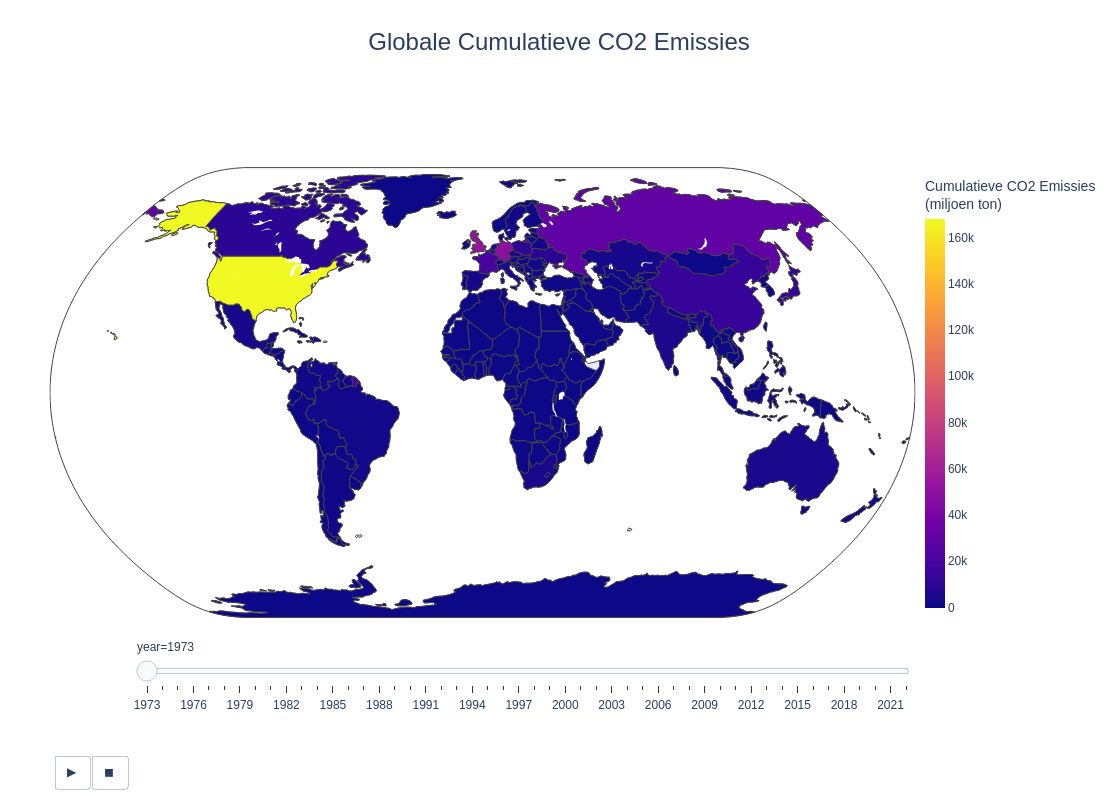

In [101]:
fig = px.choropleth(final_filtered_df,
                    locations="iso_code",   # ISO-codes van landen gebruiken voor locatie
                    color="cumulative_co2",  # CO2-uitstoot als kleurschaal
                    hover_name="country",    # Toon landnamen bij hover
                    animation_frame="year",  # Animeren over de jaren
                    projection="natural earth",  # Projectiestijl van de kaart
                    title='Globale Cumulatieve CO2 Emissies tussen 1973 en 2022',
                    color_continuous_scale=px.colors.sequential.Plasma)  # Kleurenschema

# De grootte van de kaart aanpassen
fig.update_layout(
    width=1150,   # Breedte van de kaart
    height=800,   # Hoogte van de kaart
    title=dict(text='Globale Cumulatieve CO2 Emissies', x=0.5, font=dict(size=24)),  # Centreren en opmaken van de titel
    coloraxis_colorbar=dict(
        title='Cumulatieve CO2 Emissies<br>(miljoen ton)',  # Aangepaste titel om te passen
        title_font=dict(size=14),  # Aanpassen van de lettergrootte van de titel
        thicknessmode='pixels', thickness=20,
        lenmode='pixels', len=450,
        yanchor='middle', y=0.5,  # Centreren van de colorbar verticaal
        xanchor='left', x=1.0  # Plaatsen van de colorbar aan de rechterkant
    ),
    margin=dict(l=50, r=150, t=100, b=50)  # Aanpassen van marges, vergroot rechter marge
)

# Aanpassen van de animatieslider positie
fig['layout']['sliders'][0]['pad'] = dict(t=-50)  # Negatieve top padding om de slider hoger te positioneren

# Toon de kaart
fig.show()
